In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import geopandas as gpd
import json
import datetime

%matplotlib inline

## Gather
Here I'm am importing the Ford GoBike data from 2/11/2019 (when the BART shcedule was updated) to 3/16/2020 (when the bay area stay at home order was put in place), the BART stations, and the BART schedules.

First I'm going to attemp to grab all of the data out of multiple csv files. I was going to use glob, but I can't seem to load that package into the Azure Notebook.

In [2]:
path = '/kaggle/input/bikedata/Bike/'

filenames = os.listdir(path)
bike_load_dfs = []
for f in filenames:
    bike_load_dfs.append(pd.read_csv(path + f))

len(bike_load_dfs)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


14

In [3]:
for df in bike_load_dfs:
    print(df.shape)
    print(df.columns)

(258102, 15)
Index(['duration_sec', 'start_time', 'end_time', 'start_station_id',
       'start_station_name', 'start_station_latitude',
       'start_station_longitude', 'end_station_id', 'end_station_name',
       'end_station_latitude', 'end_station_longitude', 'bike_id', 'user_type',
       'bike_share_for_all_trip', 'rental_access_method'],
      dtype='object')
(239895, 14)
Index(['duration_sec', 'start_time', 'end_time', 'start_station_id',
       'start_station_name', 'start_station_latitude',
       'start_station_longitude', 'end_station_id', 'end_station_name',
       'end_station_latitude', 'end_station_longitude', 'bike_id', 'user_type',
       'bike_share_for_all_trip'],
      dtype='object')
(176799, 14)
Index(['duration_sec', 'start_time', 'end_time', 'start_station_id',
       'start_station_name', 'start_station_latitude',
       'start_station_longitude', 'end_station_id', 'end_station_name',
       'end_station_latitude', 'end_station_longitude', 'bike_id', 'user_ty

Okay, they now all have the same columns so the dfs can be combined into one.

In [4]:
bike_df = bike_load_dfs[0].copy()
for i in range(1, len(bike_load_dfs)):
    bike_df = bike_df.append(bike_load_dfs[i])

bike_df.shape

(3219908, 15)

In [5]:
bike_df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,bike_share_for_all_trip,rental_access_method
0,85457,2019-07-31 09:25:37.3410,2019-08-01 09:09:54.6000,36.0,Folsom St at 3rd St,37.783830,-122.398870,344.0,16th St Depot,37.766349,-122.396292,3491,Customer,No,NaN
1,53831,2019-07-31 18:00:10.2940,2019-08-01 08:57:21.9750,139.0,Garfield Square (25th St at Harrison St),37.751017,-122.411901,133.0,Valencia St at 22nd St,37.755213,-122.420975,2457,Customer,No,NaN
2,33674,2019-07-31 22:52:29.7910,2019-08-01 08:13:44.0100,155.0,Emeryville Public Market,37.840521,-122.293528,155.0,Emeryville Public Market,37.840521,-122.293528,2750,Customer,No,NaN
3,34546,2019-07-31 21:59:34.2580,2019-08-01 07:35:21.0440,41.0,Golden Gate Ave at Polk St,37.781270,-122.418740,73.0,Pierce St at Haight St,37.771793,-122.433708,303,Subscriber,No,NaN
4,40244,2019-07-31 20:20:37.5420,2019-08-01 07:31:21.6060,339.0,Jackson St at 11th St,37.800002,-122.266438,233.0,4th Ave at E 12th St (Temporary Location),37.795913,-122.255547,2637,Subscriber,No,NaN


In [6]:
bike_df.dtypes

duration_sec                 int64
start_time                  object
end_time                    object
start_station_id           float64
start_station_name          object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_name            object
end_station_latitude       float64
end_station_longitude      float64
bike_id                      int64
user_type                   object
bike_share_for_all_trip     object
rental_access_method        object
dtype: object

It appears that some of the files have "rental access method" and some have "bike share for all trip" columns. I will not be using these, so they will be dropped and these dataframes will be merged.

In [7]:
bike_df = bike_df.drop(labels = ['rental_access_method', 'bike_share_for_all_trip'], axis = 1)
bike_df.shape

(3219908, 13)

Saving should be like voting, save early and save often. Or as another saying I've heard "Jesus saves. So do all his aposiles. You should too."

In [8]:
bike_df.to_csv('bike_uncleaned.csv', index = False)

## Assess
I've already noticed a few things about the data from a quick look at the csv. First, the station data is repeated, there's a station ID, name, latitude, and longitude in every entry. This is going to need to stay in as there is out of station parking, but I'm still going to create a station df so I can look at things using this.

Second, I noticed that I'm going to need the time/date stamp split up into date, time, and day of the week. While I could keep running the functions everytime I need them, it would be easier if they were by them selves.

In [9]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3219908 entries, 0 to 183411
Data columns (total 13 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   duration_sec             int64  
 1   start_time               object 
 2   end_time                 object 
 3   start_station_id         float64
 4   start_station_name       object 
 5   start_station_latitude   float64
 6   start_station_longitude  float64
 7   end_station_id           float64
 8   end_station_name         object 
 9   end_station_latitude     float64
 10  end_station_longitude    float64
 11  bike_id                  int64  
 12  user_type                object 
dtypes: float64(6), int64(2), object(5)
memory usage: 343.9+ MB


Well there's something else; start and end times should be time date. When spliting up the date/time, I'll have to see if they ever go over more than one calander day.

Also, change the station IDs to integers.

For some reason, Kaggle's Kernals doesn't give the number of non null values automatically in it. Oops, I need to look at that info.

In [10]:
for col in bike_df.columns:
    print(col + ' non-null: ' + str(bike_df[col].count()))

duration_sec non-null: 3219908
start_time non-null: 3219908
end_time non-null: 3219908
start_station_id non-null: 2653120
start_station_name non-null: 2654954
start_station_latitude non-null: 3219908
start_station_longitude non-null: 3219908
end_station_id non-null: 2651472
end_station_name non-null: 2653298
end_station_latitude non-null: 3219908
end_station_longitude non-null: 3219908
bike_id non-null: 3219908
user_type non-null: 3219908


Why are there missing station ids, but no missing station latitude and longitude?

In [11]:
bike_df.describe()

,duration_sec,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bike_id
count,3.219908e+06,2.653120e+06,3.219908e+06,3.219908e+06,2.651472e+06,3.219908e+06,3.219908e+06,3.219908e+06
mean,8.107874e+02,1.520671e+02,3.775976e+01,-1.223514e+02,1.476139e+02,3.775896e+01,-1.223477e+02,1.185211e+05
std,1.906809e+03,1.275987e+02,1.697095e-01,4.369634e-01,1.266359e+02,2.542666e-01,7.532377e-01,2.377402e+05
min,6.000000e+01,3.000000e+00,0.000000e+00,-1.225143e+02,3.000000e+00,0.000000e+00,-1.225758e+02,4.000000e+00
25%,3.640000e+02,4.900000e+01,3.776813e+01,-1.224160e+02,4.300000e+01,3.776904e+01,-1.224136e+02,2.458000e+03
50%,5.800000e+02,1.090000e+02,3.777877e+01,-1.223997e+02,1.040000e+02,3.777982e+01,-1.223990e+02,6.339000e+03
75%,9.040000e+02,2.450000e+02,3.779450e+01,-1.223888e+02,2.420000e+02,3.779519e+01,-1.223888e+02,1.272500e+04
max,9.121100e+05,5.210000e+02,4.551000e+01,0.000000e+00,5.210000e+02,4.551000e+01,0.000000e+00,9.999600e+05


The latitude has a minimum of 0 and latitude has a maximum of 0. As I know the bay area doesn't extend to the equator or the prime meridian, I know something's wrong with that. It's probably not entered; I'll see if the station of these have a correct latitude and longitude elsewhere in the data.

Next thing from this, it looks like at least one bike was out for 10.5 days. This means I'll need to keep the data for both the start and end times. Also it looks like the bikes are usually only borrowed for a few minutes, leading me to believe that these are more for commuting than for pleasure riding.

In [12]:
bike_df.nunique()

duration_sec                 16122
start_time                 3158302
end_time                   3157959
start_station_id               455
start_station_name             473
start_station_latitude      319514
start_station_longitude     339228
end_station_id                 455
end_station_name               473
end_station_latitude        322394
end_station_longitude       343103
bike_id                      14633
user_type                        2
dtype: int64

A few interesting things about the number of unique values. There are 14,633 bikes in the system, and two user types (subscriber and customer... not sure what the difference is). The start and end times are nearly all unique which makes sense. The durration strikes me as a little strange as a little strange, I'd expect a lot more here but it's probably just a bunch of short rides. There are 455 station IDs, but 473 names; did the stations change name or did they move? At the same time, there are over 300 thousand latitudes and longitudes; this probably means that they are too precise and I'll need to round them a bit to get the station location (find the mean see the max and min for each station to figure it out).

In [13]:
#looking at the durrations via a log 
duration_log = bike_df['duration_sec'].apply(np.log10)
duration_log.head()

0    4.931748
1    4.731032
2    4.527295
3    4.538398
4    4.604701
Name: duration_sec, dtype: float64

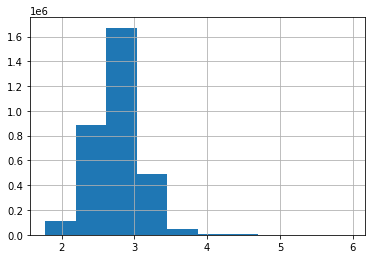

In [14]:
duration_log.hist()

Wow, even the log of the the durration is right skewed. It does look like about 2 million are between 100 seconds (1 min, 40 sec) and 1000 seconds (16 min, 40 sec). Let's look at the time intervals.

In [15]:
print('Number 1 second or more: ' + str(bike_df[bike_df['duration_sec'] > 0].shape[0]))
print('Number 1 minute or more: ' + str(bike_df[bike_df['duration_sec'] > 60].shape[0]))
print('Number 1 hour or more: ' + str(bike_df[bike_df['duration_sec'] > 3600].shape[0]))
print('Number 1 day or more: ' + str(bike_df[bike_df['duration_sec'] > 86400].shape[0]))
print('Number 1 week or more: ' + str(bike_df[bike_df['duration_sec'] > 604800].shape[0]))

Number 1 second or more: 3219908
Number 1 minute or more: 3219687
Number 1 hour or more: 40254
Number 1 day or more: 2
Number 1 week or more: 2


There are 221 less than one minute. Only about 1.25% are over an hour. Only 2 that are more than a day. When looking at duration, the 2 that are more than a day are major outliers and will be removed from analysis of duration (2 people forgot that they borrowed the bike and thought it was their's).

In [16]:
# look at the zero longitude and latitude
bike_df[bike_df['start_station_longitude'] == 0].shape[0]

36

In [17]:
bike_df[bike_df['start_station_longitude'] == 0]['start_station_id'].value_counts()

449.0    35
420.0     1
Name: start_station_id, dtype: int64

In [18]:
bike_df[bike_df['start_station_latitude'] == 0].shape[0]

36

In [19]:
bike_df[bike_df['start_station_latitude'] == 0]['start_station_longitude'].value_counts()

0.0    36
Name: start_station_longitude, dtype: int64

In [20]:
bike_df[bike_df['end_station_longitude'] == 0].shape[0]

117

In [21]:
bike_df[bike_df['end_station_longitude'] == 0]['end_station_id'].value_counts()

449.0    98
420.0    19
Name: end_station_id, dtype: int64

In [22]:
bike_df[bike_df['end_station_latitude'] == 0].shape[0]

117

In [23]:
bike_df[bike_df['end_station_latitude'] == 0]['end_station_longitude'].value_counts()

0.0    117
Name: end_station_longitude, dtype: int64

Okay it looks like station 420 and 449 are the only two with 0s for latitude and longitude. Let's see if either of these has any different values. This can easily be done just with a count; if the counts are more then the numbers with 0s then there's another latitude and longitude value I can use.

In [24]:
bike_df[bike_df['start_station_id'] == 420].shape[0]

1

In [25]:
bike_df[bike_df['start_station_id'] == 449].shape[0]

35

In [26]:
bike_df[bike_df['end_station_id'] == 420].shape[0]

19

In [27]:
bike_df[bike_df['end_station_id'] == 449].shape[0]

98

In [28]:
bike_df[(bike_df['start_station_id'] == 420) | 
        (bike_df['start_station_id'] == 449)][['start_station_id', 'start_station_name']].value_counts()

start_station_id  start_station_name           
449.0             16th Depot Bike Fleet Station    35
420.0             SF Test Station                   1
dtype: int64

These two stations do not appear to be actual places that people can check bikes out of. This is probably a registry of taking them in or out of service. They will be deleted.

In [29]:
# Looking into duplicate station names.
stations = bike_df[['start_station_id', 'start_station_name']].drop_duplicates()
stations.shape

(486, 2)

In [30]:
station_name_count = stations[['start_station_id', 'start_station_name']].groupby('start_station_id').agg('count')
station_name_count.shape

(455, 1)

In [31]:
station_name_dup = station_name_count[station_name_count['start_station_name'] > 1]
station_name_dup.shape

(15, 1)

15 stations with multiple names let's look at these.

In [32]:
bike_df[bike_df['start_station_id'].isin(station_name_dup.index)][['start_station_id','start_station_name']].value_counts()

start_station_id  start_station_name                 
16.0              Steuart St at Market St                29822
47.0              4th St at Harrison St                  11711
321.0             5th St at Folsom                       10516
323.0             Broadway at Kearny                      9916
349.0             Howard St at Mary St                    9137
37.0              Folsom St at 2nd St                     6708
16.0              Market St at Steuart St                 4992
37.0              2nd St at Folsom St                     4967
321.0             Folsom St at 5th St                     4009
277.0             Morrison Ave at Julian St               1983
                  W Julian St at N Morrison St            1338
289.0             5th St at Taylor St                      929
316.0             1st St at San Carlos St                  652
290.0             George St at 1st St                      384
224.0             21st St at 5th Ave                       378
3

Looks like some of these are just the street names inverted, but others look like different intersection all together. I need to see which ones are just that and which ones are different. Those that are different, I'll be firing up google maps.

In [33]:
for id in station_name_dup.index:
    print(bike_df[bike_df['start_station_id'] == id][['start_station_id','start_station_name']].value_counts())

start_station_id  start_station_name     
16.0              Steuart St at Market St    29822
                  Market St at Steuart St     4992
dtype: int64
start_station_id  start_station_name 
37.0              Folsom St at 2nd St    6708
                  2nd St at Folsom St    4967
dtype: int64
start_station_id  start_station_name   
47.0              4th St at Harrison St    11711
                  Clara St at 4th St         243
dtype: int64
start_station_id  start_station_name            
224.0             21st St at 5th Ave                378
                  21st Ave at International Blvd     85
dtype: int64
start_station_id  start_station_name       
229.0             Foothill Blvd at 42nd Ave    326
                  Bond St at High St            23
dtype: int64
start_station_id  start_station_name                 
234.0             Fruitvale Ave at International Blvd    103
                  Farnam St at Fruitvale Ave              75
dtype: int64
start_station_id  start_sta

Bay Wheels has a map where you can search for the stations by name. Only one of the names comes up with a station. Here's the station name that actually registers
* 16: Market St at Steuart St
* 37: Folsom St at 2nd St
* 47: Clara St at 4th St 
* 224: 21st St at 5th Ave
* 229: Bond St at High St
* 234: Fruitvale Ave at International Blvd
* 277: W Julian St at N Morrison St
* 289: 5th St at Taylor St
* 290: George St at 1st St
* 316: 1st St at San Carlos St 
* 321: Folsom St at 5th St
* 323: Broadway at Kearny St
* 349: Howard St at 6th St
* 378: 7th St at Empire St
* 393: Asbury St at The Alameda

I will use this to create a dictionary to fix these.

Now let's check and make sure these are the same as the end station.

In [34]:
stations_end = bike_df[['end_station_id', 'end_station_name']].drop_duplicates()
station_name_count_end = stations_end[['end_station_id', 'end_station_name']].groupby('end_station_id').agg('count')
station_name_dup_end = station_name_count_end[station_name_count_end['end_station_name'] > 1]
station_name_dup.index == station_name_dup_end.index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

So they are the same. We will only have to fix it with one dictionary.

Now for looking at the latitude and longitude differences. There are 69 miles in 1 degree latitude, and at 37.77 degrees north (latitude of San Francisco), 1 degree longitude is 54 miles (which will be a good approximation for the whole bay area). Going by station, I'm going find the difference between the min and max latitudes and longitudes to see if there's anything significant difference.

In [35]:
start_min_max = bike_df[['start_station_id', 'start_station_latitude', 
                         'start_station_longitude']].groupby('start_station_id').agg(['min', 'max'])
start_min_max.columns

MultiIndex([( 'start_station_latitude', 'min'),
            ( 'start_station_latitude', 'max'),
            ('start_station_longitude', 'min'),
            ('start_station_longitude', 'max')],
           )

In [36]:
start_min_max['lat_dif'] = start_min_max[('start_station_latitude', 'max')] - start_min_max[('start_station_latitude', 'min')]
start_min_max['lon_dif'] = start_min_max[('start_station_longitude', 'max')] - start_min_max[('start_station_longitude', 'min')]
start_min_max.head()

start_station_latitude            start_station_longitude  \
                                    min        max                     min   
start_station_id                                                             
3.0                           37.786375  37.786375             -122.404904   
4.0                           37.785881  37.785881             -122.408915   
5.0                           37.783899  37.783899             -122.408445   
6.0                           37.804770  37.804770             -122.403234   
7.0                           37.804562  37.804562             -122.271738   

                             lat_dif lon_dif  
                         max                  
start_station_id                              
3.0              -122.404904     0.0     0.0  
4.0              -122.408915     0.0     0.0  
5.0              -122.408445     0.0     0.0  
6.0              -122.403234     0.0     0.0  
7.0              -122.271738     0.0     0.0

In [37]:
start_min_max['lat_dif'].max(), start_min_max['lon_dif'].max()

(7.791972853899999, 48.82000000000001)

In [38]:
end_min_max = bike_df[['end_station_id', 'end_station_latitude', 
                         'end_station_longitude']].groupby('end_station_id').agg(['min', 'max'])
end_min_max['lat_dif'] = end_min_max[('end_station_latitude', 'max')] - end_min_max[('end_station_latitude', 'min')]
end_min_max['lon_dif'] = end_min_max[('end_station_longitude', 'max')] - end_min_max[('end_station_longitude', 'min')]
end_min_max['lat_dif'].max(), end_min_max['lon_dif'].max()

(7.791972853899999, 48.82000000000001)

That's 538 miles difference north/south and 2,636 miles east/west... That can't be right, that's about 2/3 of the distance of California from south to north and 5/6 of the distance across the US east to west. Let's look at everything over 0.001 degrees (365 ft NS and 285 ft EW).

In [39]:
start_wrong_lat = start_min_max[start_min_max['lat_dif'] > 0.001].index
start_wrong_lon = start_min_max[start_min_max['lon_dif'] > 0.001].index
end_wrong_lat = end_min_max[end_min_max['lat_dif'] > 0.001].index
end_wrong_lon = end_min_max[end_min_max['lon_dif'] > 0.001].index

len(start_wrong_lat), len(start_wrong_lon), len(end_wrong_lat), len(end_wrong_lon)

(5, 7, 5, 7)

In [40]:
start_wrong_lat, start_wrong_lon, end_wrong_lat, end_wrong_lon

(Float64Index([224.0, 229.0, 289.0, 316.0, 408.0], dtype='float64', name='start_station_id'),
 Float64Index([47.0, 224.0, 289.0, 290.0, 316.0, 393.0, 408.0], dtype='float64', name='start_station_id'),
 Float64Index([224.0, 229.0, 289.0, 316.0, 408.0], dtype='float64', name='end_station_id'),
 Float64Index([47.0, 224.0, 289.0, 290.0, 316.0, 393.0, 408.0], dtype='float64', name='end_station_id'))

In [41]:
for id in start_wrong_lon:
    print(bike_df[bike_df['start_station_id'] == id][['start_station_id','start_station_latitude', 
                                                     'start_station_longitude']].value_counts())

start_station_id  start_station_latitude  start_station_longitude
47.0              37.780955               -122.399749                11711
                  37.780675               -122.400811                  243
dtype: int64
start_station_id  start_station_latitude  start_station_longitude
224.0             37.800459               -122.247459                378
                  37.784855               -122.239305                 85
dtype: int64
start_station_id  start_station_latitude  start_station_longitude
289.0             37.351017               -121.895921                788
                  37.350902               -121.895843                141
                  37.349998               -121.898010                118
dtype: int64
start_station_id  start_station_latitude  start_station_longitude
290.0             37.347732               -121.899464                305
                  37.347047               -121.898321                100
                  37.347593         

Except for station 408 (which appears to occationally teleport to Montreal, Canada) all of these we can either average out or take the most frequent latitude or longitude. Just in case, I'm going to check the end station to make sure there's not too much variation.

In [42]:
for id in end_wrong_lon:
    print(bike_df[bike_df['end_station_id'] == id][['end_station_id','end_station_latitude', 
                                                     'end_station_longitude']].value_counts())

end_station_id  end_station_latitude  end_station_longitude
47.0            37.780955             -122.399749              11260
                37.780675             -122.400811                275
dtype: int64
end_station_id  end_station_latitude  end_station_longitude
224.0           37.800459             -122.247459              378
                37.784855             -122.239305              107
dtype: int64
end_station_id  end_station_latitude  end_station_longitude
289.0           37.351017             -121.895921              842
                37.349998             -121.898010              154
                37.350902             -121.895843              128
dtype: int64
end_station_id  end_station_latitude  end_station_longitude
290.0           37.347732             -121.899464              343
                37.347047             -121.898321               94
                37.347593             -121.899662               73
dtype: int64
end_station_id  end_station_latitu

In [43]:
#Let's make sure that the non-station locations are not out of state or on Mars.
bike_df[bike_df['start_station_id'].isnull()][['start_station_latitude', 'start_station_longitude']].describe()

,start_station_latitude,start_station_longitude
count,566788.000000,566788.000000
mean,37.720548,-122.342632
std,0.151416,0.207588
min,36.163261,-122.514299
25%,37.761395,-122.421922
50%,37.776337,-122.406757
75%,37.788646,-122.393863
max,37.895300,-86.775177


In [44]:
bike_df[bike_df['end_station_id'].isnull()][['end_station_latitude', 'end_station_longitude']].describe()

,end_station_latitude,end_station_longitude
count,568436.000000,568436.000000
mean,37.718838,-122.340706
std,0.153376,0.209498
min,36.163140,-122.575763
25%,37.761117,-122.422004
50%,37.776254,-122.406791
75%,37.788640,-122.393605
max,37.995942,-86.775177


Okay, it looks like the latitude has a min a little south of the bay area and a max a little north of the bay area. The longitude is more disturbing in that someone rode the bike all the way to somewhere around Iowa... Let's look closer at these.

In [45]:
bike_df[bike_df['start_station_latitude'] < 37].shape[0] + bike_df[bike_df['end_station_latitude'] < 37].shape[0]

164

In [46]:
bike_df[bike_df['start_station_latitude'] > 38].shape[0] + bike_df[bike_df['end_station_latitude'] > 38].shape[0]

12

In [47]:
bike_df[bike_df['start_station_longitude'] > -121].shape[0] + bike_df[bike_df['end_station_longitude'] > -121].shape[0]

175

Oops, looks like I included the stations as well. Well we already know that 153 are marked as 0 latitude and longitude, and 8 were in Montrial. So that means that there are 4 non-station bikes north of 38 degrees, 11 south of 37 degrees, and 14 east of -121. I'll drop these outliers.

There are more non-null station names than station ids. It might be that these are stations that actually have numbers, but they weren't entered, or there's a station or stations that don't have numbers. Let's look at this. 

In [48]:
no_name_start = bike_df[(bike_df['start_station_id'].isnull()) & 
                        (bike_df['start_station_name'].notnull())][['start_time', 'start_station_name']]
#added start time so I have something to count on.
no_name_start.head()

,start_time,start_station_name
174113,2019-07-15 17:22:51,1st St at San Carlos Ave
174118,2019-07-26 16:40:21,1st St at San Carlos Ave
174121,2019-07-10 19:12:19,1st St at San Carlos Ave
174122,2019-07-09 12:58:52,1st St at San Carlos Ave
174125,2019-07-29 08:26:26,1st St at San Carlos Ave


In [49]:
no_name_start.groupby('start_station_name').agg('count')

,start_time
start_station_name,
1st St at San Carlos Ave,72
2nd St at Folsom St,161
4th St at Harrison St,304
5th St at Folsom,154
5th St at Taylor St,7
Broadway at Kearny,171
Clement St at 32nd Avenue,62
Empire St at 7th St,30
Farnam St at Fruitvale Ave,4


In [50]:
no_name_end = bike_df[(bike_df['end_station_id'].isnull()) & 
                        (bike_df['end_station_name'].notnull())][['start_time', 'end_station_name']]
no_name_end.groupby('end_station_name').agg('count')

,start_time
end_station_name,
1st St at San Carlos Ave,62
2nd St at Folsom St,151
4th St at Harrison St,321
5th St at Folsom,139
5th St at Taylor St,7
Broadway at Kearny,174
Clement St at 32nd Avenue,65
Empire St at 7th St,27
Farnam St at Fruitvale Ave,3


In [51]:
for name in pd.unique(no_name_end['end_station_name']):
    print(name +"    "+ str(bike_df[(bike_df['end_station_id'].notnull()) & 
            (bike_df['end_station_name'] == name)]['end_station_name'].count()))

Morrison Ave at Julian St    1861
1st St at San Carlos Ave    353
George St at 1st St    416
Empire St at 7th St    243
5th St at Taylor St    970
5th St at Folsom    10693
2nd St at Folsom St    4421
Farnam St at Fruitvale Ave    77
Green St at Van Ness St    0
4th St at Harrison St    11260
Broadway at Kearny    8532
Clement St at 32nd Avenue    0
N 3rd St at E Taylor St    154
Jackson St at N 1st St    94
Steuart St at Market St    30656


Okay, all but two of these actually have station numbers, just they weren't recorded. I can definitly add those in. It looks like the first zero may have just changed ave to st as I got a 'Green St at Van Ness Ave' station on the Bay Wheel's map. And the other one shouldn't have spelled out Avenue as I got a 'Clement St at 32nd Ave'. Let's just check to make sure those are in the data.

In [52]:
corrected_station = ['Green St at Van Ness Ave', 'Clement St at 32nd Ave']
for name in corrected_station:
    print(name +"    "+ str(bike_df[(bike_df['end_station_id'].notnull()) & 
            (bike_df['end_station_name'] == name)]['end_station_name'].count()))

Green St at Van Ness Ave    29
Clement St at 32nd Ave    66


Okay, I found that I can get the station number for each of these.

### Task list
* Change start and end times to date time.
* Remove everything before 2/11/19 (when I have BART schedule information) and after 3/15/20 (as the stay at home order started the next day).
* Fill in station IDs for those that have station names.
* Add 'station ID' of -1 and 'non-station' for the station name for all records that didn't start or end at
    a station
* Remove data with stations 420 and 449.
* Change station IDs to integers.
* Correct the names for the stations with more than one name
* Replace the Montreal coordinates to the most common coordiantes at that station.
* Average out the latitudes and longitues of the stations.
* Remove the two trips that were over a week long.
* Remove data for outlier/incorrect latitude and longitude.
* Get the data, time, and day of the week into seperate columns (I will have to change the original column title
    fromtime to time_stamp). Edit: as there is no data or time data types, I won't be able to order using this 
    so I won't split this.
* Create a dataframe with the station data (for easy look up of data).

## Cleaning
I'm going to start by reducing my data to the dates in question (2/11/19 - 3/15/20). This will mean first changing them to data/time.

In [53]:
bike_df_not_clean = bike_df.copy()

In [54]:
bike_df = bike_df_not_clean.copy()
bike_df.shape

(3219908, 13)

In [55]:
#oops, there are multiple indexs that are the same. When I tried to drop by index I lost more rows then
#I should have. Let's reset that index first.
bike_df.set_index(np.arange(bike_df.shape[0]), drop = True, inplace = True)
bike_df.tail()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type
3219903,480,2019-02-01 00:04:49.7240,2019-02-01 00:12:50.0340,27.0,Beale St at Harrison St,37.788059,-122.391865,324.0,Union Square (Powell St at Post St),37.788300,-122.408531,4832,Subscriber
3219904,313,2019-02-01 00:05:34.7440,2019-02-01 00:10:48.5020,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,66.0,3rd St at Townsend St,37.778742,-122.392741,4960,Subscriber
3219905,141,2019-02-01 00:06:05.5490,2019-02-01 00:08:27.2200,278.0,The Alameda at Bush St,37.331932,-121.904888,277.0,Morrison Ave at Julian St,37.333658,-121.908586,3824,Subscriber
3219906,139,2019-02-01 00:05:34.3600,2019-02-01 00:07:54.2870,220.0,San Pablo Ave at MLK Jr Way,37.811351,-122.273422,216.0,San Pablo Ave at 27th St,37.817827,-122.275698,5095,Subscriber
3219907,271,2019-02-01 00:00:20.6360,2019-02-01 00:04:52.0580,24.0,Spear St at Folsom St,37.789677,-122.390428,37.0,2nd St at Folsom St,37.785000,-122.395936,1057,Subscriber


In [56]:
bike_df['start_time'] = pd.to_datetime(bike_df['start_time'])
bike_df['end_time'] = pd.to_datetime(bike_df['end_time'])
bike_df.dtypes

duration_sec                        int64
start_time                 datetime64[ns]
end_time                   datetime64[ns]
start_station_id                  float64
start_station_name                 object
start_station_latitude            float64
start_station_longitude           float64
end_station_id                    float64
end_station_name                   object
end_station_latitude              float64
end_station_longitude             float64
bike_id                             int64
user_type                          object
dtype: object

In [57]:
start_date = datetime.datetime(2019, 2, 11, 0, 0, 0)
end_date = datetime.datetime(2020, 3, 16, 0, 0, 0)

start_date, end_date

(datetime.datetime(2019, 2, 11, 0, 0), datetime.datetime(2020, 3, 16, 0, 0))

In [58]:
too_early_index = bike_df[bike_df['start_time'] < start_date].index
len(too_early_index)

57519

In [59]:
bike_df.drop(index = too_early_index, inplace = True)
bike_df.shape

(3162389, 13)

In [60]:
too_late_index = bike_df[bike_df['end_time'] > end_date].index
len(too_late_index)

39995

In [61]:
bike_df.drop(index = too_late_index, inplace = True)
bike_df.shape

(3122394, 13)

Now time to make some corrections to the stations, starting with adding the station ID to the stations that have a name and missing ID.

In [62]:
no_id = bike_df[(bike_df['end_station_id'].isnull()) & 
                        (bike_df['end_station_name'].notnull())][['end_station_name']].drop_duplicates()[
    'end_station_name']
no_id

170814      Morrison Ave at Julian St
170829       1st St at San Carlos Ave
172453            George St at 1st St
173202            Empire St at 7th St
178150            5th St at Taylor St
183154               5th St at Folsom
183592            2nd St at Folsom St
205676     Farnam St at Fruitvale Ave
579116        Green St at Van Ness St
580992          4th St at Harrison St
587119             Broadway at Kearny
591592      Clement St at 32nd Avenue
992849        N 3rd St at E Taylor St
1000105        Jackson St at N 1st St
2285702       Steuart St at Market St
Name: end_station_name, dtype: object

In [63]:
bike_df[bike_df['end_station_name'].isin(no_id)][['end_station_id', 'end_station_name']].value_counts()

end_station_id  end_station_name          
16.0            Steuart St at Market St       29948
47.0            4th St at Harrison St         10975
321.0           5th St at Folsom              10343
323.0           Broadway at Kearny             8295
37.0            2nd St at Folsom St            4274
277.0           Morrison Ave at Julian St      1779
289.0           5th St at Taylor St             930
290.0           George St at 1st St             399
316.0           1st St at San Carlos Ave        353
378.0           Empire St at 7th St             232
289.0           N 3rd St at E Taylor St         154
290.0           Jackson St at N 1st St           94
234.0           Farnam St at Fruitvale Ave       73
dtype: int64

In [64]:
bike_df[bike_df['end_station_name'].isin(['Green St at Van Ness Ave',
                                         'Clement St at 32nd Ave'])][['end_station_id', 
                                                                      'end_station_name']].value_counts()

end_station_id  end_station_name        
516.0           Clement St at 32nd Ave      33
496.0           Green St at Van Ness Ave    16
dtype: int64

In [65]:
no_id_list = no_id.tolist()
no_id_list

['Morrison Ave at Julian St',
 '1st St at San Carlos Ave',
 'George St at 1st St',
 'Empire St at 7th St',
 '5th St at Taylor St',
 '5th St at Folsom',
 '2nd St at Folsom St',
 'Farnam St at Fruitvale Ave',
 'Green St at Van Ness St',
 '4th St at Harrison St',
 'Broadway at Kearny',
 'Clement St at 32nd Avenue',
 'N 3rd St at E Taylor St',
 'Jackson St at N 1st St',
 'Steuart St at Market St']

In [66]:
#manually making a list of ids so I can match up the values and make a dictionary
correct_id = [496, 47, 323, 516, 289, 290, 16, 277, 316, 290, 378, 289, 321, 37, 234]
id_correction = {no_id_list[i]: correct_id[i] for i in range(len(no_id_list))}
id_correction

{'Morrison Ave at Julian St': 496,
 '1st St at San Carlos Ave': 47,
 'George St at 1st St': 323,
 'Empire St at 7th St': 516,
 '5th St at Taylor St': 289,
 '5th St at Folsom': 290,
 '2nd St at Folsom St': 16,
 'Farnam St at Fruitvale Ave': 277,
 'Green St at Van Ness St': 316,
 '4th St at Harrison St': 290,
 'Broadway at Kearny': 378,
 'Clement St at 32nd Avenue': 289,
 'N 3rd St at E Taylor St': 321,
 'Jackson St at N 1st St': 37,
 'Steuart St at Market St': 234}

In [67]:
for key, value in id_correction.items():
    bike_df.loc[bike_df['start_station_name'] == key, 'start_station_id'] = value
    bike_df.loc[bike_df['end_station_name'] == key, 'end_station_id'] = value

In [68]:
for key in id_correction.items():
    print(bike_df[(bike_df['start_station_name'] == key) & 
            (bike_df['start_station_id']).isnull()][['start_station_name']].count())
    print(bike_df[(bike_df['end_station_name'] == key) & 
            (bike_df['end_station_id']).isnull()][['end_station_name']].count())

start_station_name    0
dtype: int64
end_station_name    0
dtype: int64
start_station_name    0
dtype: int64
end_station_name    0
dtype: int64
start_station_name    0
dtype: int64
end_station_name    0
dtype: int64
start_station_name    0
dtype: int64
end_station_name    0
dtype: int64
start_station_name    0
dtype: int64
end_station_name    0
dtype: int64
start_station_name    0
dtype: int64
end_station_name    0
dtype: int64
start_station_name    0
dtype: int64
end_station_name    0
dtype: int64
start_station_name    0
dtype: int64
end_station_name    0
dtype: int64
start_station_name    0
dtype: int64
end_station_name    0
dtype: int64
start_station_name    0
dtype: int64
end_station_name    0
dtype: int64
start_station_name    0
dtype: int64
end_station_name    0
dtype: int64
start_station_name    0
dtype: int64
end_station_name    0
dtype: int64
start_station_name    0
dtype: int64
end_station_name    0
dtype: int64
start_station_name    0
dtype: int64
end_station_name    0
dtype

In [69]:
for col in ['start_station_id', 'start_station_name', 'end_station_id', 'end_station_name']:
    print(col + ': ' + str(bike_df[col].count()))

start_station_id: 2572964
start_station_name: 2572964
end_station_id: 2571571
end_station_name: 2571571


That appears to have worked.

Now time to fill in the blanks with -1 and non-station.

In [70]:
bike_df.fillna({'start_station_id': -1, 'start_station_name': 'non-station', 
                'end_station_id': -1, 'end_station_name': 'non-station'}, inplace = True)

for col in ['start_station_id', 'start_station_name', 'end_station_id', 'end_station_name']:
    print(col + ': ' + str(bike_df[col].count()))

start_station_id: 3122394
start_station_name: 3122394
end_station_id: 3122394
end_station_name: 3122394


Now the nulls are -1 or 'non-station'.

Time to remove the stations thare aren't public (420 and 449), which are all the ones with a zero latitude & longitude

In [71]:
zero_coord = bike_df[(bike_df['start_station_latitude'] == 0) | 
                     (bike_df['end_station_latitude'] == 0)].index
len(zero_coord)

152

In [72]:
#one less than I counted earlier, so let's see if that one got purged when I set the date range.
len(bike_df_not_clean[(bike_df_not_clean['start_station_latitude'] == 0) | 
                     (bike_df_not_clean['end_station_latitude'] == 0)].index)

153

In [73]:
#yeap, that's why I missed one. Now time to remove these from the bike dataframe.
bike_df.drop(index = zero_coord, inplace = True)
bike_df.shape

(3122242, 13)

Just to make it a little cleaner, I'm going to change the station IDs to integers instead of floats. I could change these to strings, but I just don't feel like putting quotes around the ids throughout the project...

In [74]:
bike_df = bike_df.astype({'bike_id':'int64','start_station_id':'int64','end_station_id':'int64'})
bike_df.dtypes

duration_sec                        int64
start_time                 datetime64[ns]
end_time                   datetime64[ns]
start_station_id                    int64
start_station_name                 object
start_station_latitude            float64
start_station_longitude           float64
end_station_id                      int64
end_station_name                   object
end_station_latitude              float64
end_station_longitude             float64
bike_id                             int64
user_type                          object
dtype: object

Okay, it's time to standardize the station names.

In [75]:
id_name = {16: 'Market St at Steuart St', 37: 'Folsom St at 2nd St', 47: 'Clara St at 4th St', 
           224: '21st St at 5th Ave', 229: 'Bond St at High St', 234: 'Fruitvale Ave at International Blvd', 
           277: 'W Julian St at N Morrison St', 289: '5th St at Taylor St', 290: 'George St at 1st St', 
           316: '1st St at San Carlos St', 321: 'Folsom St at 5th St', 323: 'Broadway at Kearny St', 
           349: 'Howard St at 6th St', 378: '7th St at Empire St', 393: 'Asbury St at The Alameda', 
           516: 'Clement St at 32nd Ave', 496: 'Green St at Van Ness Ave'}

for key, value in id_name.items():
    bike_df.loc[bike_df['start_station_id'] == key, 'start_station_name'] = value
    bike_df.loc[bike_df['end_station_id'] == key, 'end_station_name'] = value



In [76]:
for key in id_name:
    print(bike_df[bike_df['start_station_id'] == key]['start_station_name'].value_counts())
    print(bike_df[bike_df['end_station_id'] == key]['end_station_name'].value_counts())

Market St at Steuart St    9824
Name: start_station_name, dtype: int64
Market St at Steuart St    9624
Name: end_station_name, dtype: int64
Folsom St at 2nd St    6723
Name: start_station_name, dtype: int64
Folsom St at 2nd St    5597
Name: end_station_name, dtype: int64
Clara St at 4th St    586
Name: start_station_name, dtype: int64
Clara St at 4th St    624
Name: end_station_name, dtype: int64
21st St at 5th Ave    430
Name: start_station_name, dtype: int64
21st St at 5th Ave    448
Name: end_station_name, dtype: int64
Bond St at High St    339
Name: start_station_name, dtype: int64
Bond St at High St    298
Name: end_station_name, dtype: int64
Fruitvale Ave at International Blvd    29818
Name: start_station_name, dtype: int64
Fruitvale Ave at International Blvd    30632
Name: end_station_name, dtype: int64
W Julian St at N Morrison St    1399
Name: start_station_name, dtype: int64
W Julian St at N Morrison St    1193
Name: end_station_name, dtype: int64
5th St at Taylor St    926
N

All of these ids only have one name now.

Now getting station 408 out of Montreal and back to the bay area.

In [77]:
bike_df[bike_df['end_station_id'] == 408][['end_station_id','end_station_latitude', 
                                                     'end_station_longitude']].value_counts()

end_station_id  end_station_latitude  end_station_longitude
408             37.718027             -122.387862              22
                45.510000             -73.570000                4
                37.718513             -122.388320               4
                37.720000             -122.390000               2
dtype: int64

In [78]:
print(bike_df[bike_df['start_station_latitude'] == 45.510000].head())
print(bike_df[bike_df['end_station_latitude'] == 45.510000].head())

         duration_sec              start_time                end_time  \
695930           4212 2019-06-27 07:31:51.684 2019-06-27 08:42:04.399   
1642674          3885 2019-08-13 11:08:07.325 2019-08-13 12:12:52.507   
1712058           335 2019-08-02 14:03:06.648 2019-08-02 14:08:41.900   
1719939           348 2019-08-01 10:50:05.912 2019-08-01 10:55:54.012   

         start_station_id start_station_name  start_station_latitude  \
695930                408        MTL-ECO5-01                   45.51   
1642674               408        MTL-ECO5-01                   45.51   
1712058               408        MTL-ECO5-01                   45.51   
1719939               408        MTL-ECO5-01                   45.51   

         start_station_longitude  end_station_id end_station_name  \
695930                    -73.57             408      MTL-ECO5-01   
1642674                   -73.57             408      MTL-ECO5-01   
1712058                   -73.57             408      MTL-ECO5-01 

Actually, looking at this, the bike starts and stops at the same station at the same latitude and longitude and a strange station name. This could be another bike sharing data in Montreal. I'm going to delete these instead of changing the latitude and longitude.

In [79]:
mont_index = bike_df[bike_df['start_station_latitude'] == 45.510000].index
bike_df.drop(index = mont_index, inplace = True)
bike_df.shape

(3122238, 13)

Now for consistancy, I'm going average out the latitudes and longitudes of the stations for just one in each station.

In [80]:
stations_start = bike_df[bike_df['start_station_id'] != -1][['start_station_id', 
                                                             'start_station_latitude', 'start_station_longitude']]
stations_end = bike_df[bike_df['end_station_id'] != -1][['end_station_id', 
                                                             'end_station_latitude', 'end_station_longitude']]
stations_start.rename(columns = {'start_station_id':'station_id', 'start_station_latitude': 'station_latitude', 
                               'start_station_longitude':'station_longitude'}, inplace = True)
stations_start.columns

Index(['station_id', 'station_latitude', 'station_longitude'], dtype='object')

In [81]:
stations_end.rename(columns = {'end_station_id':'station_id', 'end_station_latitude': 'station_latitude', 
                               'end_station_longitude':'station_longitude'}, inplace = True)
stations = stations_start.append(stations_end)
stations.head()

,station_id,station_latitude,station_longitude
0,36,37.783830,-122.398870
1,139,37.751017,-122.411901
2,155,37.840521,-122.293528
3,41,37.781270,-122.418740
4,339,37.800002,-122.266438


In [82]:
stations_mean = stations.groupby('station_id').agg('mean')
stations_mean.head()

,station_latitude,station_longitude
station_id,,
3,37.786375,-122.404904
4,37.785881,-122.408915
5,37.783899,-122.408445
6,37.804770,-122.403234
7,37.804562,-122.271738


In [83]:
stations_mean.columns

Index(['station_latitude', 'station_longitude'], dtype='object')

In [84]:
lat_dict = {}
lon_dict = {}
for index in stations_mean.index:
    lat_dict.update({index: round(stations_mean['station_latitude'][index], 6)})
    lon_dict.update({index: round(stations_mean['station_longitude'][index], 6)})

lat_dict

{3: 37.786375,
 4: 37.785881,
 5: 37.783899,
 6: 37.80477,
 7: 37.804562,
 8: 37.799953,
 9: 37.798572,
 10: 37.795393,
 11: 37.79728,
 12: 37.796389,
 13: 37.794231,
 14: 37.795001,
 15: 37.795392,
 16: 37.79009,
 17: 37.792251,
 18: 37.850222,
 19: 37.788975,
 20: 37.7913,
 21: 37.789625,
 22: 37.789756,
 23: 37.791464,
 24: 37.789677,
 25: 37.787064,
 26: 37.78729,
 27: 37.788059,
 28: 37.787168,
 29: 37.782405,
 30: 37.776598,
 31: 37.783813,
 33: 37.781649,
 34: 37.783988,
 35: 37.329119,
 36: 37.78383,
 37: 37.778261,
 38: 37.782926,
 39: 37.778999,
 41: 37.78127,
 42: 37.77865,
 43: 37.778768,
 44: 37.781074,
 46: 37.79014,
 47: 37.476038,
 49: 37.78076,
 50: 37.780526,
 51: 37.776101,
 52: 37.777416,
 53: 37.775946,
 54: 37.777547,
 55: 37.777053,
 56: 37.773414,
 58: 37.776619,
 59: 37.774814,
 60: 37.77452,
 61: 37.776513,
 62: 37.777791,
 63: 37.77591,
 64: 37.776754,
 65: 37.830296,
 66: 37.778742,
 67: 37.776639,
 70: 37.773311,
 71: 37.773063,
 72: 37.772406,
 73: 37.7717

In [85]:
for key in lat_dict:
    bike_df.loc[bike_df['start_station_id'] == key, 'start_station_latitude'] = lat_dict[key]
    bike_df.loc[bike_df['start_station_id'] == key, 'start_station_longitude'] = lon_dict[key]
    bike_df.loc[bike_df['end_station_id'] == key, 'end_station_latitude'] = lat_dict[key]
    bike_df.loc[bike_df['end_station_id'] == key, 'end_station_longitude'] = lon_dict[key]

bike_df[['start_station_id', 'start_station_latitude']].value_counts()

start_station_id  start_station_latitude
 58               37.776619                 47246
 81               37.775880                 45215
 30               37.776598                 43641
 15               37.795392                 39607
 21               37.789625                 36394
                                            ...  
-1                37.771137                     1
                  37.771137                     1
                  37.805175                     1
                  37.805175                     1
                  36.163261                     1
Length: 312162, dtype: int64

In [86]:
bike_df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type
0,85457,2019-07-31 09:25:37.341,2019-08-01 09:09:54.600,36,Folsom St at 3rd St,37.783830,-122.398870,344,16th St Depot,37.766349,-122.396292,3491,Customer
1,53831,2019-07-31 18:00:10.294,2019-08-01 08:57:21.975,139,Garfield Square (25th St at Harrison St),37.751017,-122.411901,133,Valencia St at 22nd St,37.755213,-122.420975,2457,Customer
2,33674,2019-07-31 22:52:29.791,2019-08-01 08:13:44.010,155,Emeryville Public Market,37.840521,-122.293528,155,Emeryville Public Market,37.840521,-122.293528,2750,Customer
3,34546,2019-07-31 21:59:34.258,2019-08-01 07:35:21.044,41,Golden Gate Ave at Polk St,37.781270,-122.418740,73,Pierce St at Haight St,37.771793,-122.433708,303,Subscriber
4,40244,2019-07-31 20:20:37.542,2019-08-01 07:31:21.606,339,Jackson St at 11th St,37.800002,-122.266438,233,4th Ave at E 12th St (Temporary Location),37.795913,-122.255547,2637,Subscriber


I've got each station at only one coordinatefor it.

Now it's time to remove the two over a week trips.

In [87]:
week_long_index = bike_df[bike_df['duration_sec'] > 604800].index
len(week_long_index)

2

In [88]:
bike_df.drop(index = week_long_index, inplace = True)
bike_df.shape

(3122236, 13)

Now time to remove any data where the latitude and longitude are out of the area.

In [89]:
south = bike_df[(bike_df['start_station_latitude'] < 37) | (bike_df['end_station_latitude'] < 37)].index.tolist()
north = bike_df[(bike_df['start_station_latitude'] > 38) | (bike_df['end_station_latitude'] > 38)].index.tolist()
east = bike_df[(bike_df['start_station_longitude'] > -121) | (bike_df['end_station_longitude'] > -121)].index.tolist()

out_of_bounds = south + north + east
len(out_of_bounds)

15

In [90]:
bike_df.drop(index = out_of_bounds, inplace = True)
bike_df.shape

(3122228, 13)

In [91]:
out_of_bounds

[226544,
 2634948,
 2634949,
 2634950,
 2634951,
 2634952,
 2534832,
 2535199,
 2534832,
 2535199,
 2634948,
 2634949,
 2634950,
 2634951,
 2634952]

I was scared for a minute, there were 15 in the list but only 8 removed. But printing out the list, there are only 8 unique values in the list.

Now time to split out the time. But first let's change to a more appropriate name.

In [92]:
bike_df['start_time'].dt.date

0          2019-07-31
1          2019-07-31
2          2019-07-31
3          2019-07-31
4          2019-07-31
              ...    
3162394    2019-02-11
3162395    2019-02-11
3162396    2019-02-11
3162397    2019-02-11
3162399    2019-02-11
Name: start_time, Length: 3122228, dtype: object

Okay, it looks like there is no date or time data types in pandas. This means I won't be able to order them using this. I'm not going to split up the start or end times.

And for my last trick, I'm going to create a station dataframe.

In [93]:
stations_start = bike_df[bike_df['start_station_id'] != -1][['start_station_id', 'start_station_name', 
                                                             'start_station_latitude', 'start_station_longitude']]
stations_end = bike_df[bike_df['end_station_id'] != -1][['end_station_id', 'end_station_name', 
                                                             'end_station_latitude', 'end_station_longitude']]
stations_start.rename(columns = {'start_station_id':'station_id', 'start_station_name':'station_name', 
                                 'start_station_latitude': 'station_latitude', 
                                 'start_station_longitude':'station_longitude'}, inplace = True)
stations_end.rename(columns = {'end_station_id':'station_id', 'end_station_name':'station_name', 
                               'end_station_latitude': 'station_latitude', 
                               'end_station_longitude':'station_longitude'}, inplace = True)
stations_df = stations_start.append(stations_end)
stations_df.head()

,station_id,station_name,station_latitude,station_longitude
0,36,Folsom St at 3rd St,37.783830,-122.398870
1,139,Garfield Square (25th St at Harrison St),37.751017,-122.411901
2,155,Emeryville Public Market,37.840521,-122.293528
3,41,Golden Gate Ave at Polk St,37.781270,-122.418740
4,339,Jackson St at 11th St,37.800002,-122.266438


In [94]:
stations_df.nunique()

station_id           449
station_name         449
station_latitude     448
station_longitude    447
dtype: int64

In [95]:
stations_df.drop_duplicates(inplace = True)
stations_df.shape

(449, 4)

## Saving
Now that things have been cleaned up, it's time to save it.

In [96]:
bike_df.to_csv('bike.csv', index = False)
stations_df.to_csv('stations.csv', index = False)